# Convolutional Neural Networks

For this homework you will train a CNN on the Hymenoptera dataset that you can download from here:

- https://download.pytorch.org/tutorial/hymenoptera_data.zip

You will code any CNN architecture that you want for this, using pytorch and/or pytorch-lightning (you can use only pytorch is you want)

## Load the dataset

**QUESTION.** Load the dataset into two dataloaders, one from training and the other for validation.

- You can use `torchvision.datasets.ImageFolder` and pass it to `DataLoader` for this, have a look at the documentation
- In the transformations, you should resize the images to make things faster (using the size of CIFAR-10's images for instance), and use some data augmentation (only for the training dataloader, of course) 

**QUESTION.** Display some images and their associated labels. You should see images of bees and ants :)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import torchvision
import torchvision.transforms as transforms
import pdb
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [102]:
workers = multiprocessing.cpu_count()

In [98]:
data_dir = "hymenoptera_data"
#Applying Transformation
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])


val_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [103]:
train_data = datasets.ImageFolder(data_dir + "/train", transform = train_transforms)                                       
val_data = datasets.ImageFolder(data_dir + "/val", transform = val_transforms)

#Data Loading
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers = workers, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=32, num_workers = workers, shuffle=True)

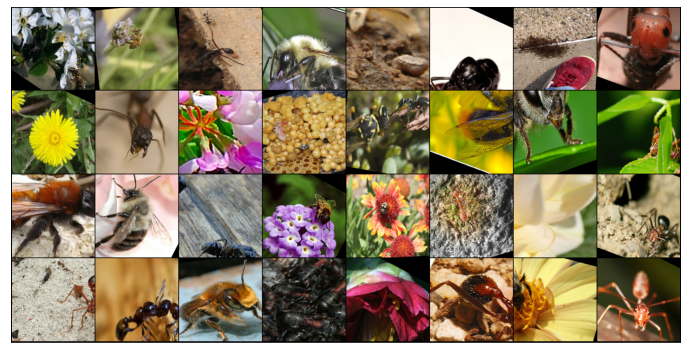

tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0])


In [104]:
def show_images(img):
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()

train_iter = iter(trainloader)
images, labels = next(train_iter)
show_images(torchvision.utils.make_grid(images))
print(labels)

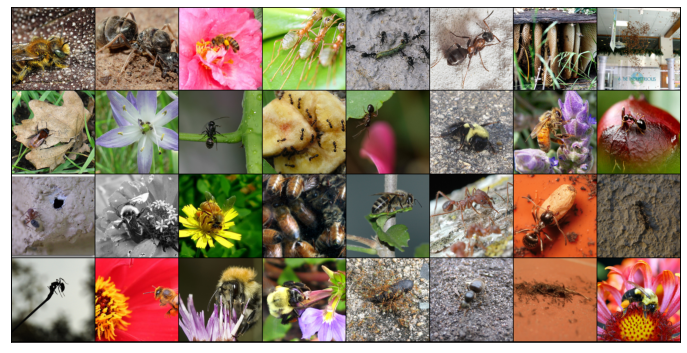

tensor([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 0])


In [106]:
valid_iter = iter(valloader)
images_valid, labels_valid = next(valid_iter)
show_images(torchvision.utils.make_grid(images_valid))
print(labels)

## Neural net architecture

You are free to define any kind of convolutional neural network that you think is reasonable for today's problem.
Remember that convolutional neural networks are usually a combination of the following building blocks:

  * Convolutional layers
  * Pooling layers
  * Linear layers
  
It is your task today to arrange these components into a reasonable architecture.

In [ ]:
import torch.nn.functional as F

# Inherit from LightningModule is you use pytorch-lightning, and you'll need to code some more methods
class ConvNet(nn.Module):

    def __init__(self, output_dim):

        super(ConvNet, self).__init__()
        
        self.encoder = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
               
        )
        
        self.classifier = nn.Sequential(
                    
        )

    def forward(self, x):
        
        
        return x
    
    
    

In [ ]:
class FashionCNN(pl.LightningModule):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=1600, out_features=600)
        self.drop = nn.Dropout2d(0.2) # Maybe change to .5
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.drop2 = nn.Dropout2d(0.3)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        self.accuracy = pl.metrics.Accuracy()

    def encoder(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        #out = self.conv_block3(out)
        return out.view(out.size(0), -1)

    def classifier(self, x):
        #import pdb; pdb.set_trace()
        #print(x.shape)
        out = self.fc1(x)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.drop2(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=5e-3)

## Training loop and checks

**QUESTION**. Code the training loop (specify the loss, etc.). Check that everything is fine, that the forward pass works and that training on a very small subset of the data works as well. Add the callbacks that you want, and prepare the logging tools that you want to use (such as tensorboard, or anything you want to use.

## Measure the performance of you model

Measure the performance of your model, and display some things (such as confusion matrix, ROC or AUC curves).
Compare several architectures, put your results in an easy to interpret pandas dataframe.

## Use fine-tuning and transfer learning

You might have noticed that training a CNN from scratch can be very slow, hard, painful, and that the overall performance might not be satisfying. 

**QUESTION.** To overcome this, use a pre-trained network and fine-tune it on the Hymenoptera dataset.
You are free to choose any pre-trained model that the PyTorch library offers evaluate and compare its performance to the CNN you have built yourself.